In [1]:
%pylab inline
plt.style.use('../matplotlib.mplstyle')

from astropy import units as u

# gala

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
import gala.integrate as gi
from gala.units import galactic

import pynbody
 
import bfe

import coefficients_smoothing
#import nba

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
coefficients_smoothing.smooth_coeff?

In [51]:
# Functions

# Path to coefficients


def get_coefficients(path, n_snaps, nmax, lmax, taxis=1):
    S_matrix = np.zeros((n_snaps, nmax+1, lmax+1, lmax+1))
    T_matrix = np.zeros((n_snaps, nmax+1, lmax+1, lmax+1))
    
    for i in range(n_snaps):
        coeff = np.loadtxt(path+"_{:03d}.txt".format(i))
        S = coeff[:,0]
        SS = coeff[:,1]
        T = coeff[:,taxis]
        TT = coeff[:,3]
        ST = coeff[:,4]
        S_matrix[i] = coefficients_smoothing.reshape_matrix(S, nmax, lmax, lmax)
        T_matrix[i] = coefficients_smoothing.reshape_matrix(T, nmax, lmax, lmax)
        SS_matrix = coefficients_smoothing.reshape_matrix(SS, nmax, lmax, lmax)
        TT_matrix = coefficients_smoothing.reshape_matrix(TT, nmax, lmax, lmax)
        ST_matrix = coefficients_smoothing.reshape_matrix(ST, nmax, lmax, lmax)

        S_matrix[i], T_matrix[i], _ = coefficients_smoothing.smooth_coeff_matrix(S_matrix[i], T_matrix[i], SS_matrix,
                                                                        TT_matrix, ST_matrix, nmax=20, 
                                                                        lmax=20, mmax=20, mass=1.853e-6, 
                                                                         sn=7, sn_out=0)
    return S_matrix, T_matrix



def get_center(coeff_path, all_info=0):
    line = linecache.getline(coeff_path,1)
    line2 = line.split(":",1)[1].rstrip('\n')
    list_str = line2.replace('[', '').replace(']', '').replace(',','').split(' ')
    list_com = list(filter(None, list_str))
    
    if all_info==1:
        nmax = int(list_com[0])
        lmax = int(list_com[2])
        rs_mw = float(list_com[4])
        pmass = float(list_com[6])
        return nmax, lmax, rs_mw, pmass
    else:
        xcom = float(list_com[8])
        ycom = float(list_com[9])
        zcom = float(list_com[10])
        return np.array([xcom, ycom, zcom])

In [4]:
orbit = np.loadtxt('./data/LMC5_100Mb1_orbit.txt')


In [5]:
 # Plot density contours 
    
# Add time level label
# LMC as a point mass
# LMC orbit
# LMC debris as particles


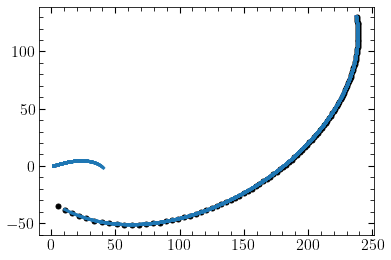

In [6]:
for k in range(110):
    plot(orbit[:k,7], orbit[:k,8], c='C0')
    plot(orbit[:k,1], orbit[:k,2], c='C0')

    scatter(orbit[k,7], orbit[k,8], c='k')
    
#xlim(-250, 250)
#ylim(-250, 250)

In [7]:
# BFEs 

In [131]:

def density_profile(S, T, grid_size, m, rs, orbit, snap):
    S0 = np.zeros_like(S)
    T0 = np.zeros_like(T)
    S0[0,0,0] = S[0,0,0]
    T0[0,0,0] = T[0,0,0]
    
    circle1 = plt.Circle((0, 0), 100, color='w', fill=False, ls='--', alpha=0.7)

    pot = gp.SCFPotential(m=m*u.Msun, r_s=rs*u.kpc, Snlm=S, Tnlm=T, units=galactic)
    #pot_0 = gp.SCFPotential(m=m*u.Msun, r_s=rs*u.kpc, Snlm=S0, Tnlm=T0, units=galactic)
    
    x0 = np.linspace(grid_size[0], grid_size[1], 128)
    y0 = np.linspace(grid_size[0], grid_size[1], 128)

    x = np.linspace(grid_size[0]-orbit[snap,1], grid_size[1]-orbit[snap,1], 128)
    y = np.linspace(grid_size[0]-orbit[snap,2], grid_size[1]-orbit[snap,2], 128)

    grid = np.meshgrid(x, y)    
    xyz = np.zeros((3, 128**2))
    xyz[1] = grid[0].flatten()
    xyz[2] = grid[1].flatten()
    
    rho = pot.density(xyz)
    #rho_0 = pot_0.density(xyz)

    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    ax.contourf(x0, y0, np.log10(np.abs(rho.value.reshape(128, 128))), 20, cmap='inferno', 
                origin='lower', vmin=-7.5, vmax=-1.5, extent=[-250, 250, -250, 250], levels=np.linspace(-8, -1.5, 20))
    
    #ax.contourf(x0, y0, (rho.value/rho_0.value).reshape(128, 128)-1 , 20, cmap='inferno', 
    #            origin='lower', vmin=-0.4, vmax=0.4, extent=[-250, 250, -250, 250])
    ax.scatter(orbit[snap,7], orbit[snap,8], c='w')
    ax.plot(orbit[:snap+1,7], orbit[:snap+1,8], lw='1.5', c='w', alpha=0.7)
    ax.add_patch(circle1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.plot([-150, -50], [-220, -220], c='w')
    ax.text( -150, -210, r'$\rm{100\ kpc}$', c='w', fontsize=22)
    ax.text( -200, 220, r'$t={:0.1f}\ $Gyr'.format(snap*0.02), c='w', fontsize=22)

    savefig('reflex_motion_{:03d}.png'.format(snap), bbox_inches='tight', dpi=300)
    #plt.close()

In [52]:
coefficients = "../mwlmc/data/BFE_MWLMC5_b1snap"
# Coefficients

S_mw, T_mw = get_coefficients(coefficients, 110, nmax=20, lmax=20, taxis=2)



/home/ngc/Work/research/MW_viz/mwlmc/coefficients_smoothing.py:142: RuntimeWarning: invalid value encountered in double_scalars
  bt = 1 / (1 + (varT/T**2))


/tmp/ipykernel_4481/3366086237.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(8,8))


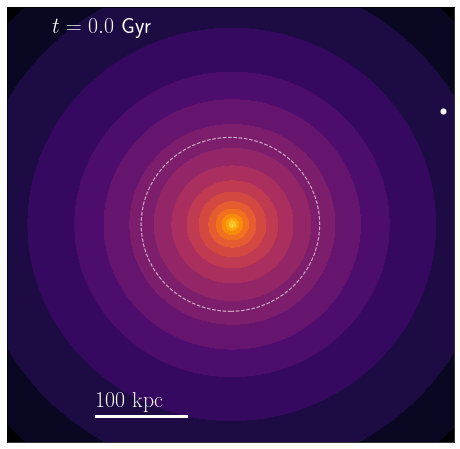

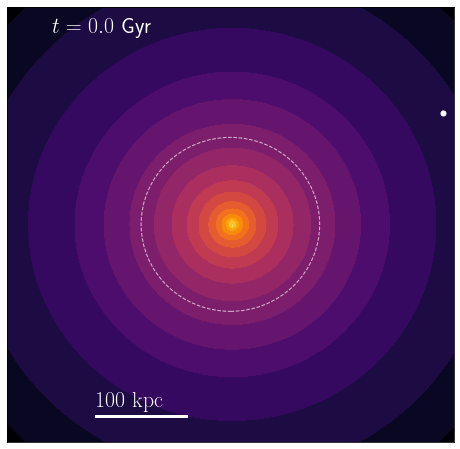

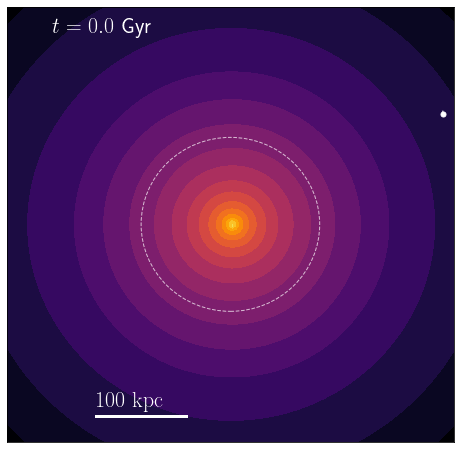

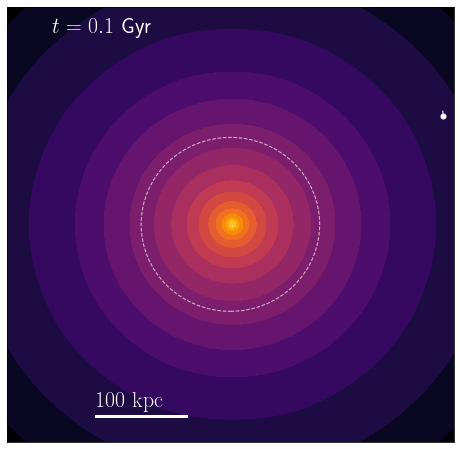

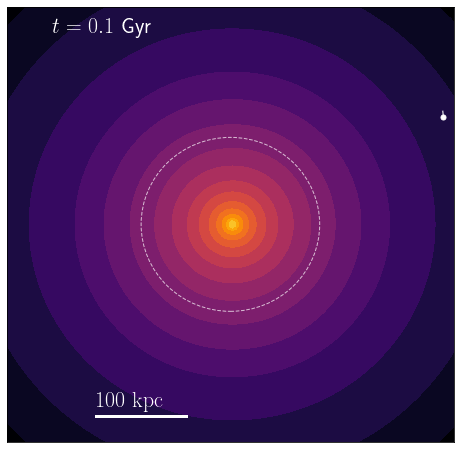

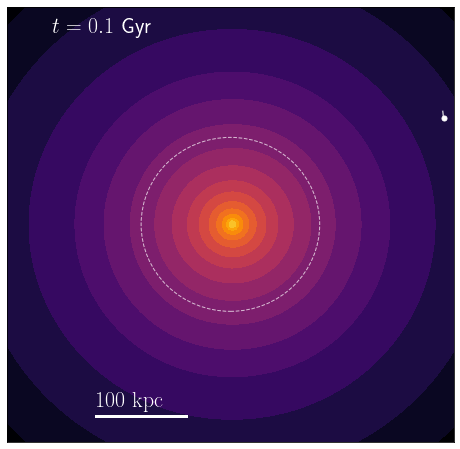

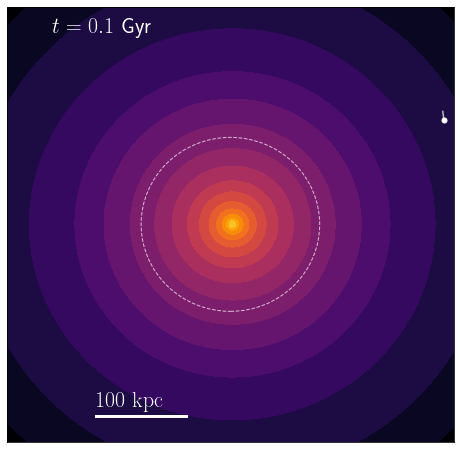

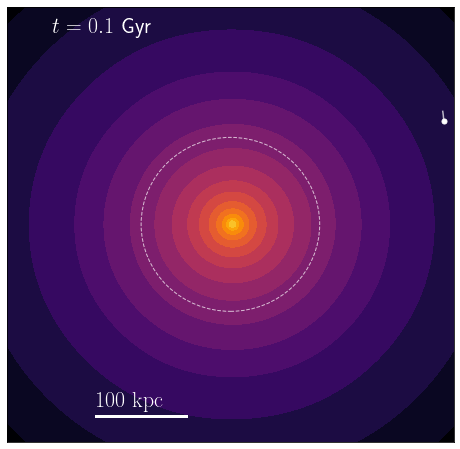

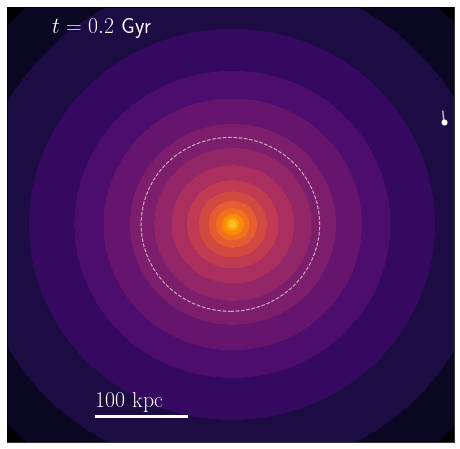

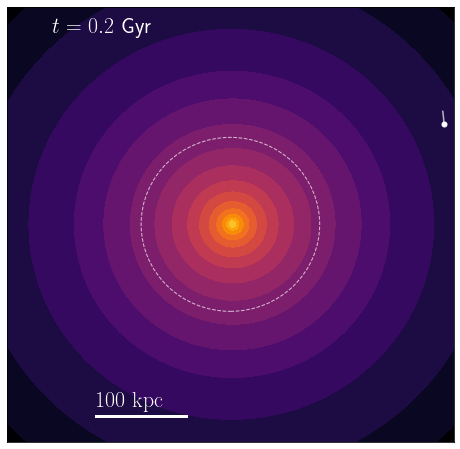

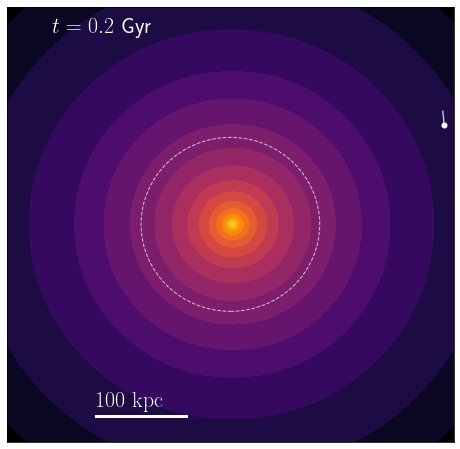

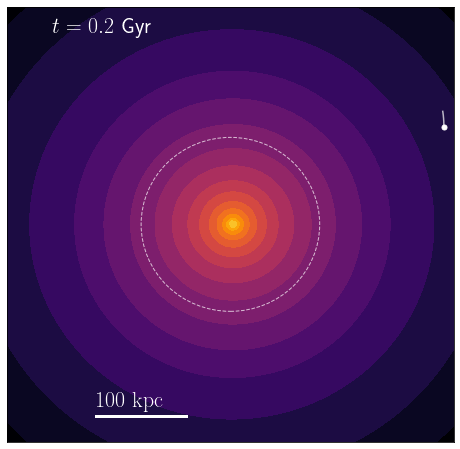

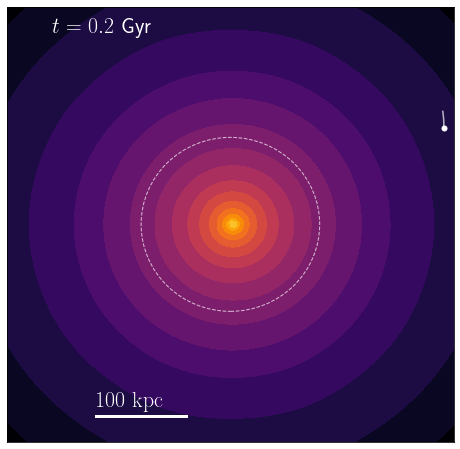

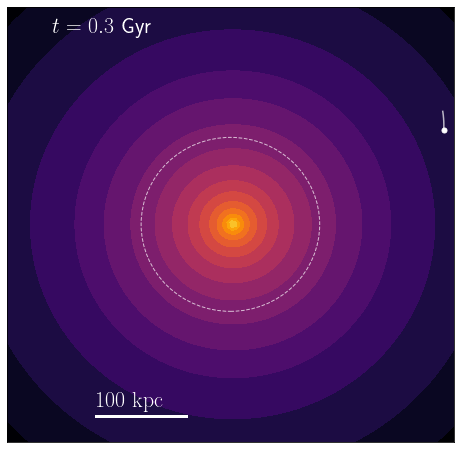

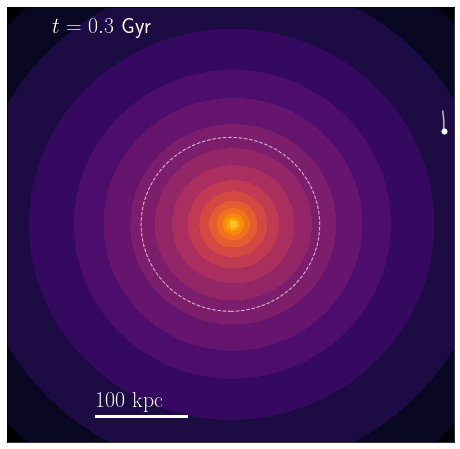

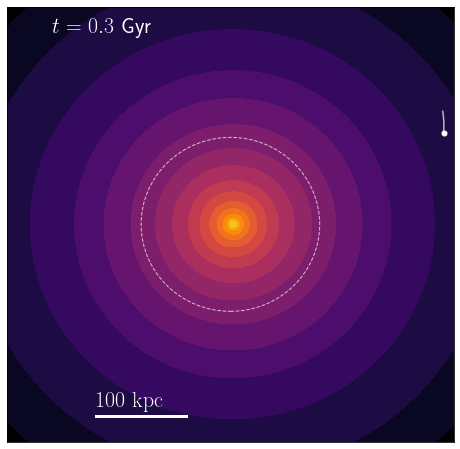

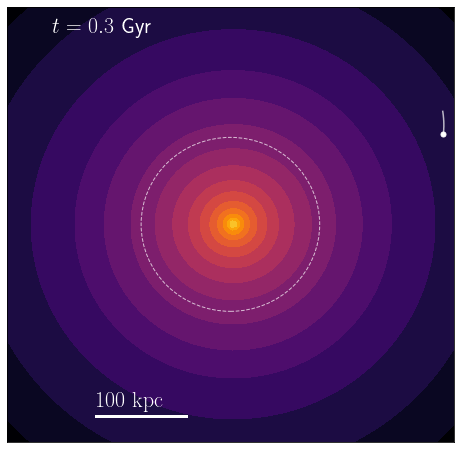

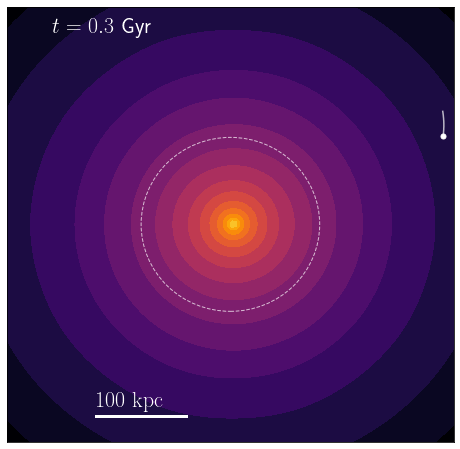

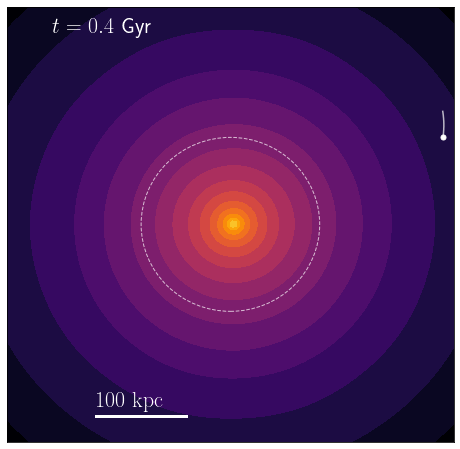

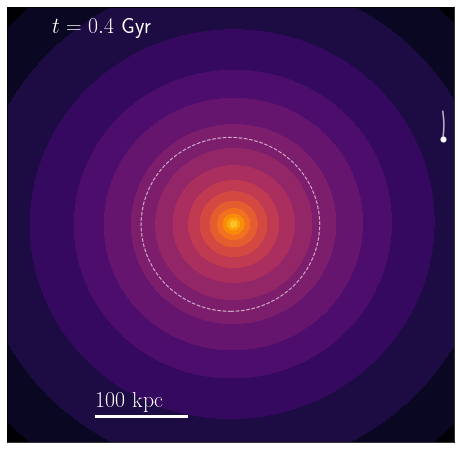

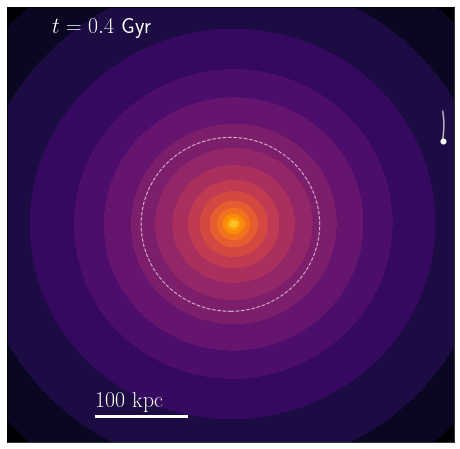

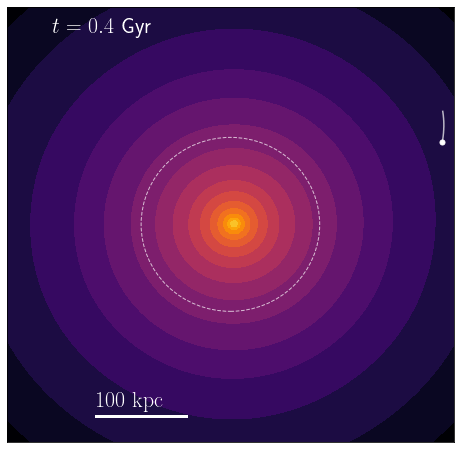

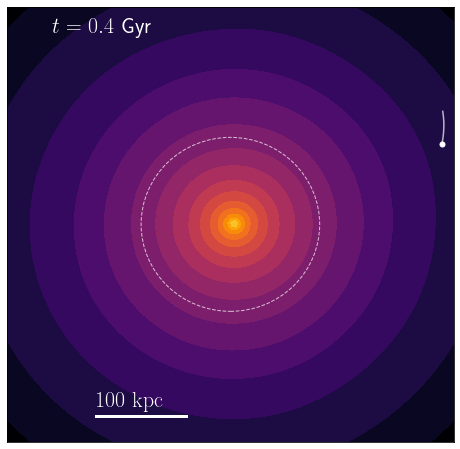

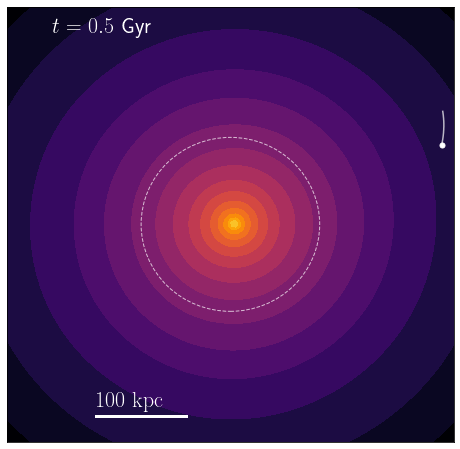

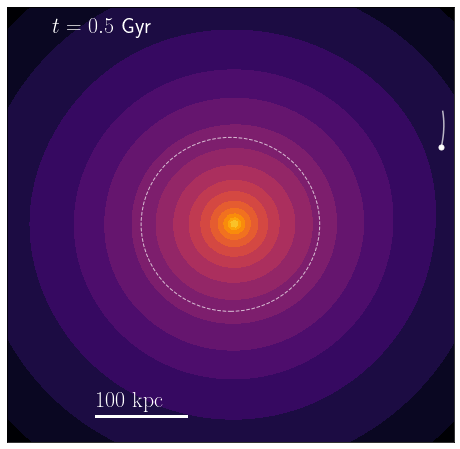

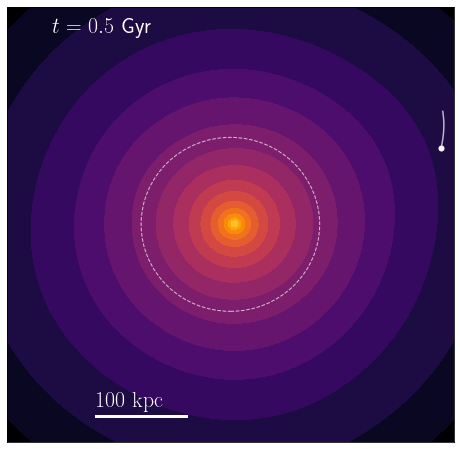

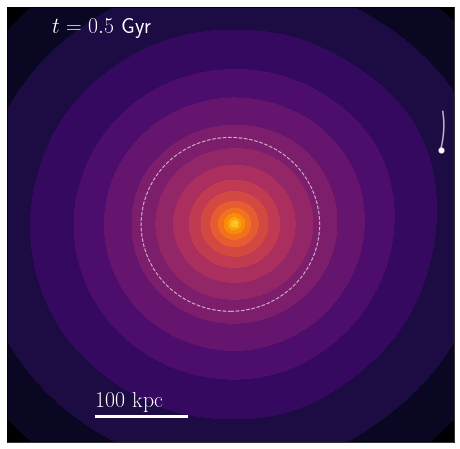

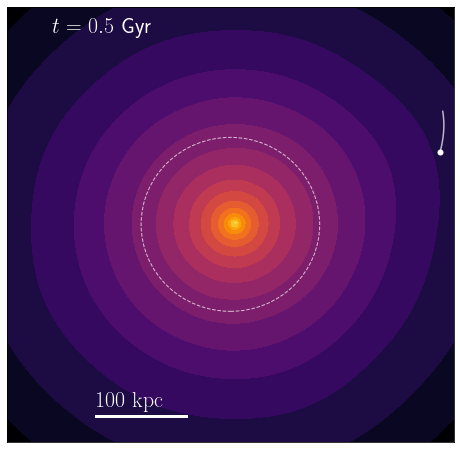

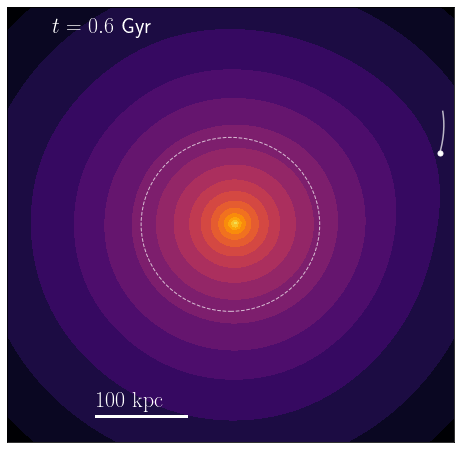

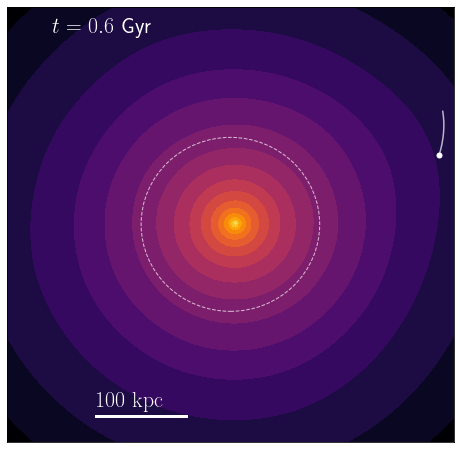

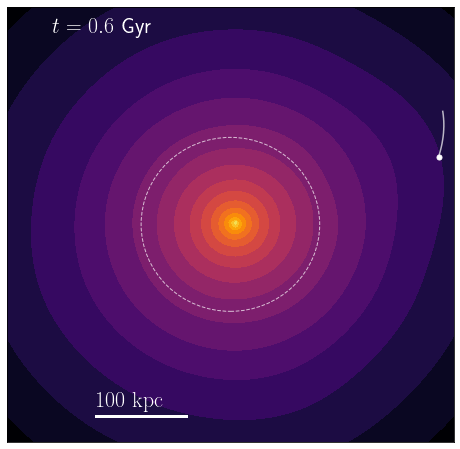

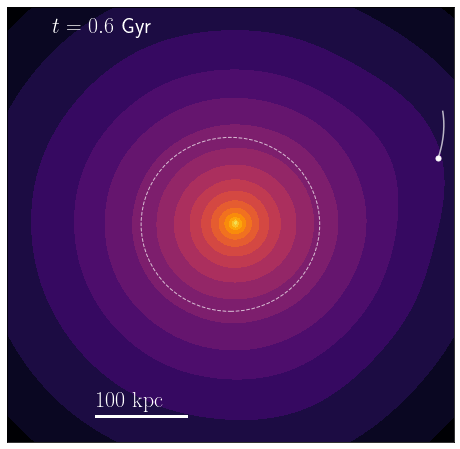

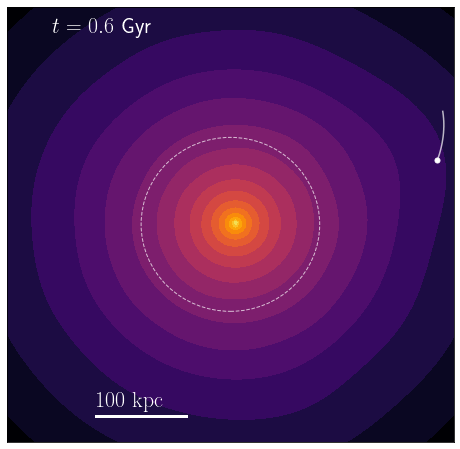

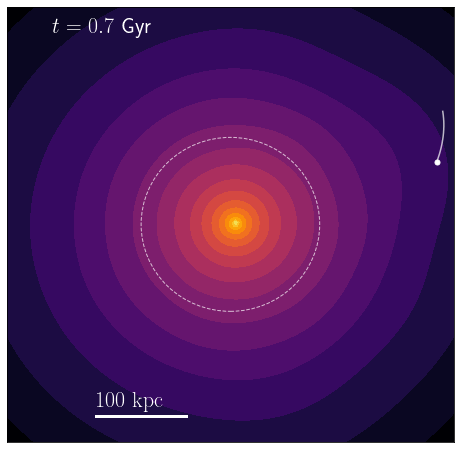

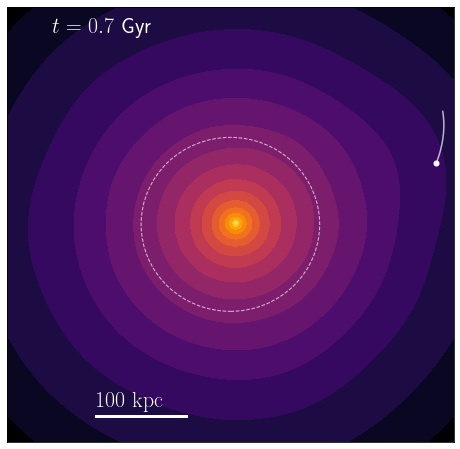

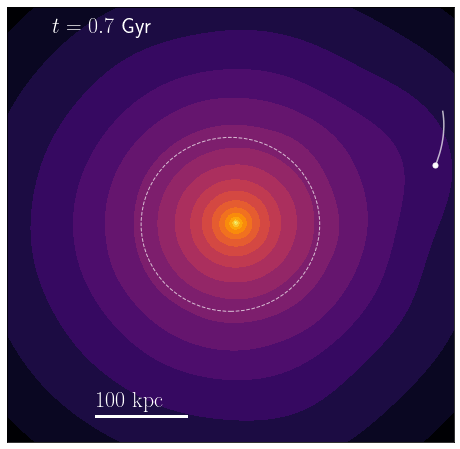

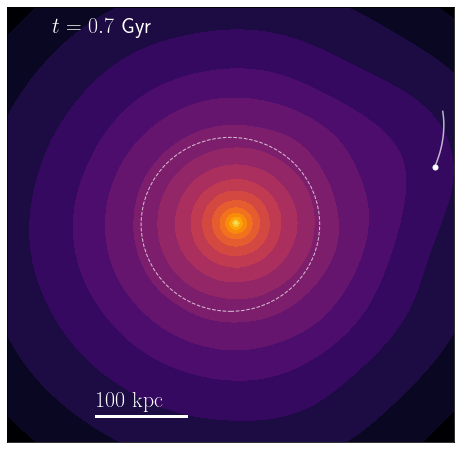

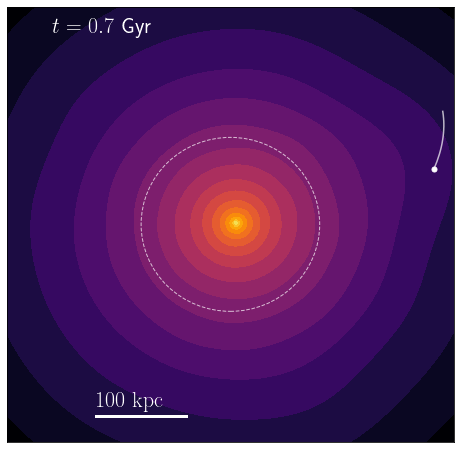

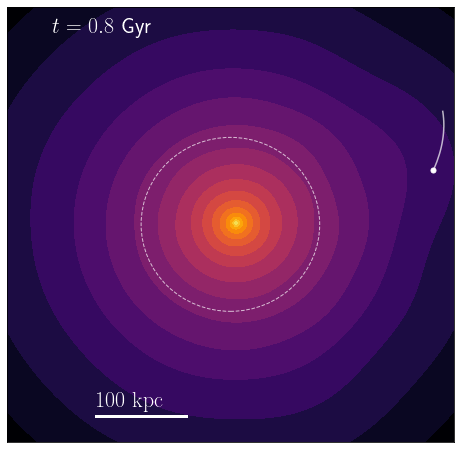

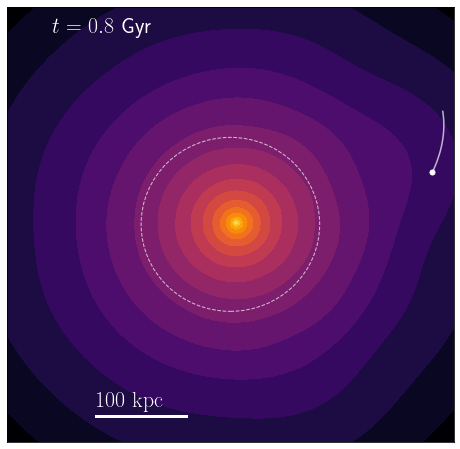

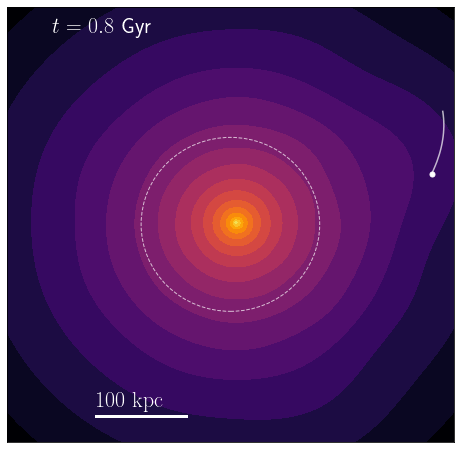

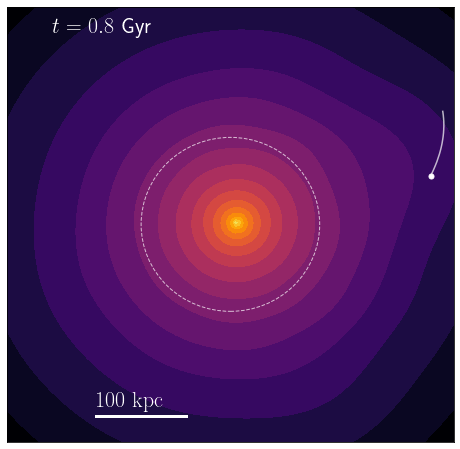

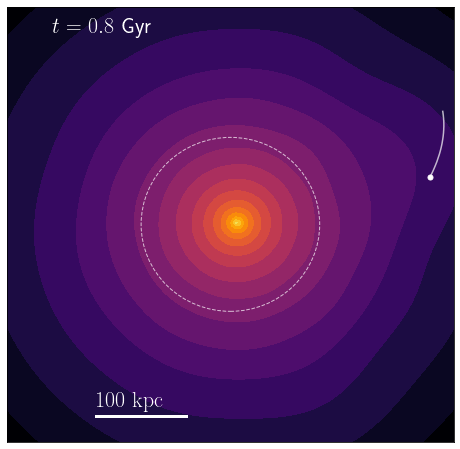

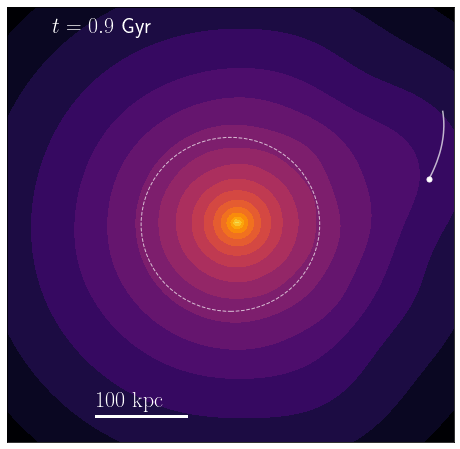

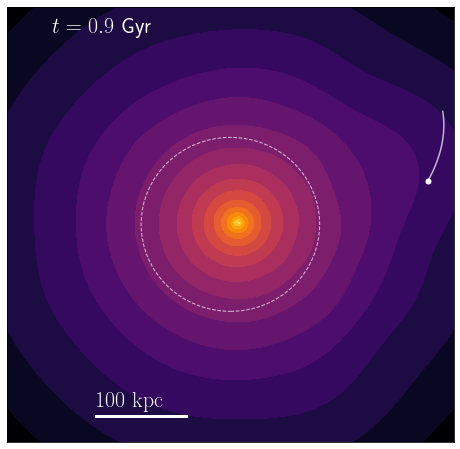

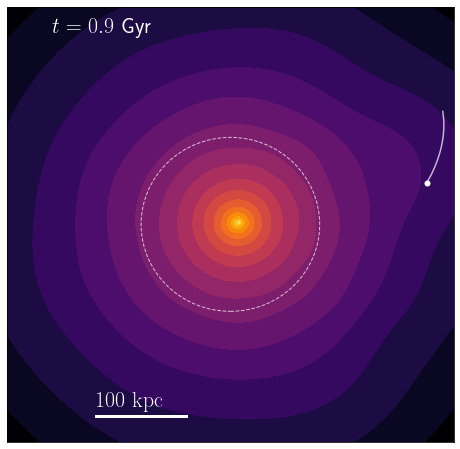

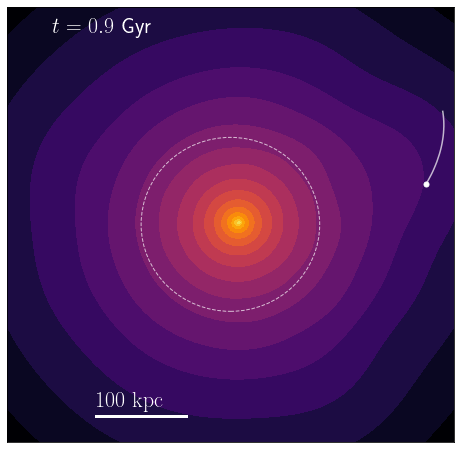

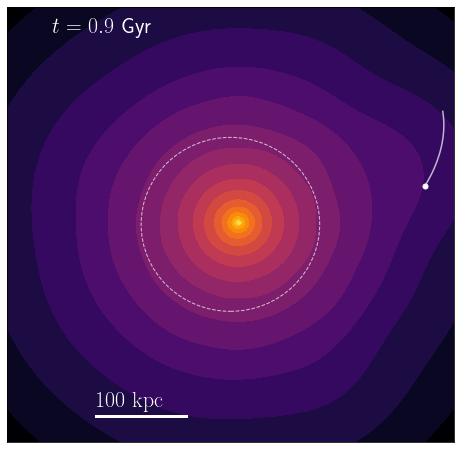

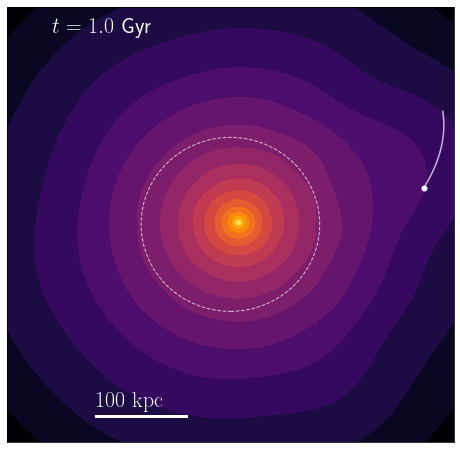

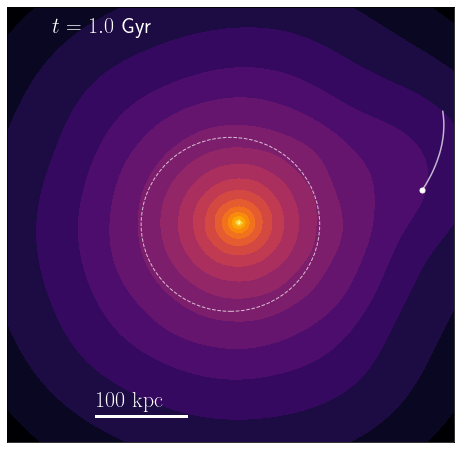

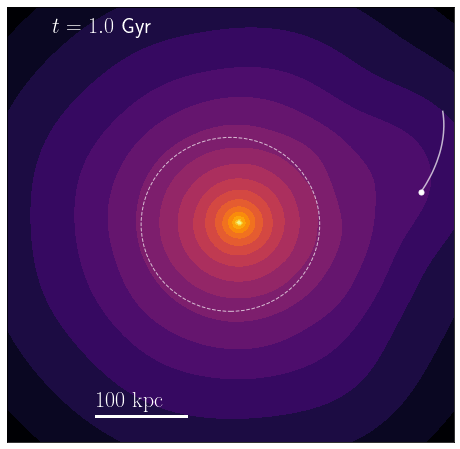

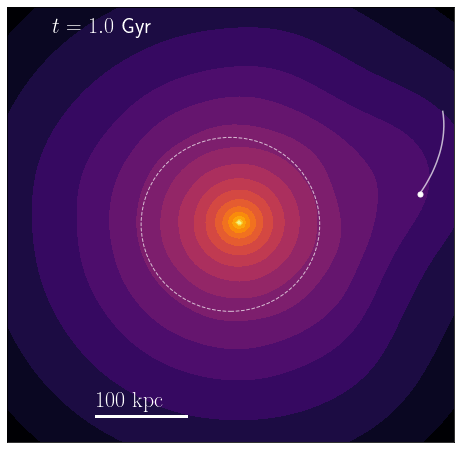

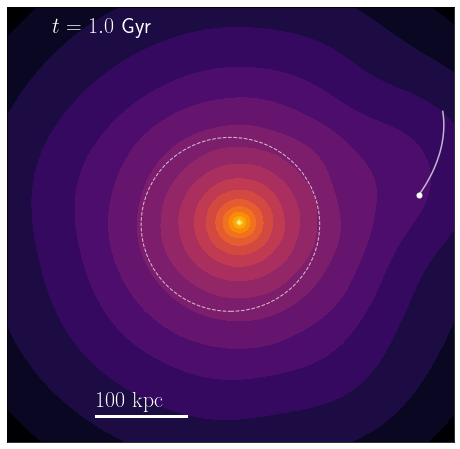

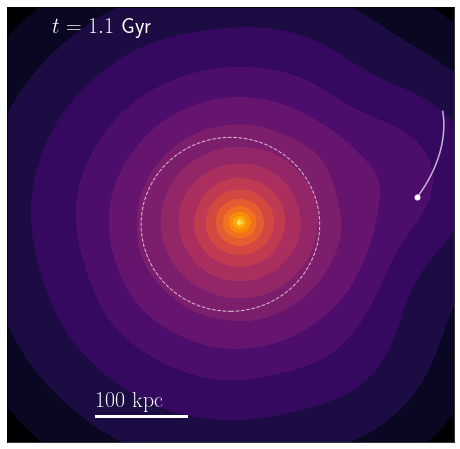

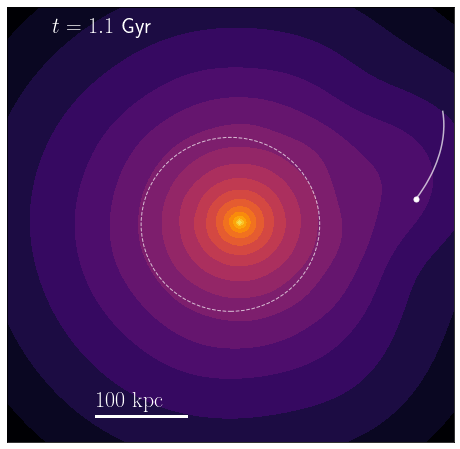

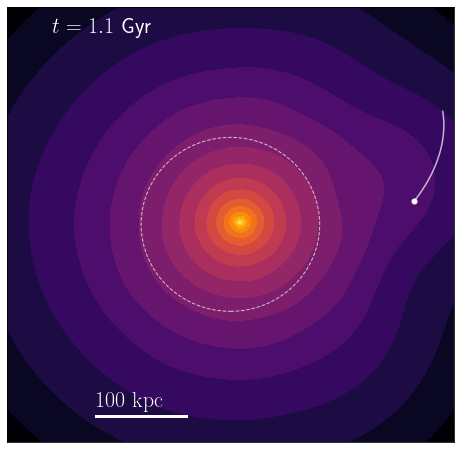

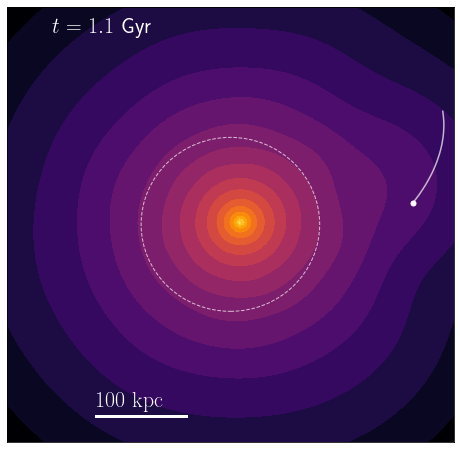

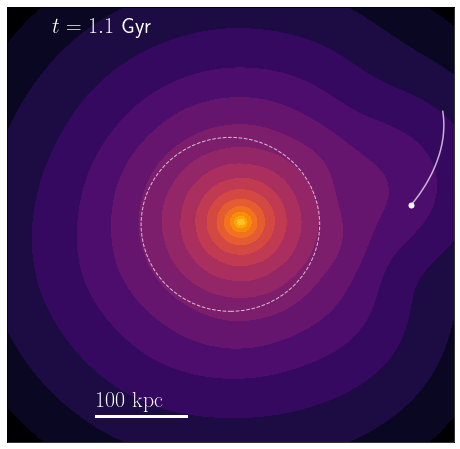

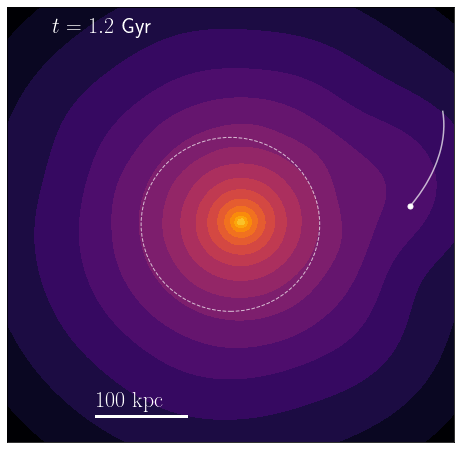

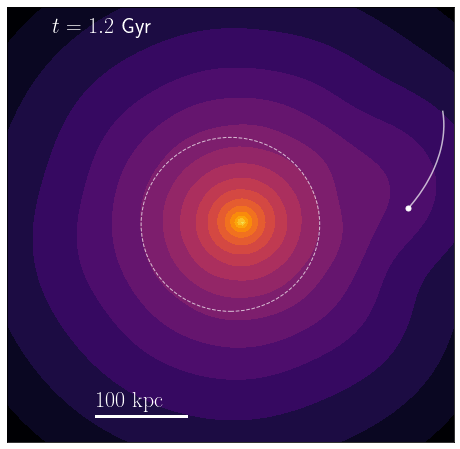

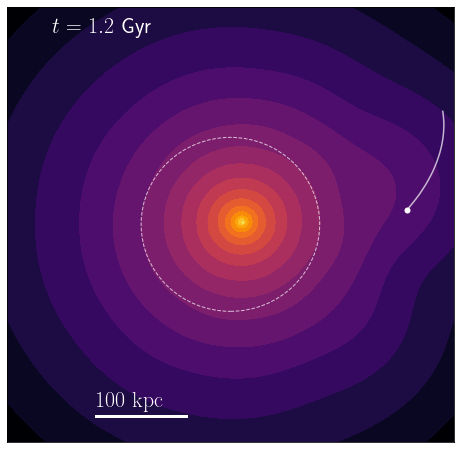

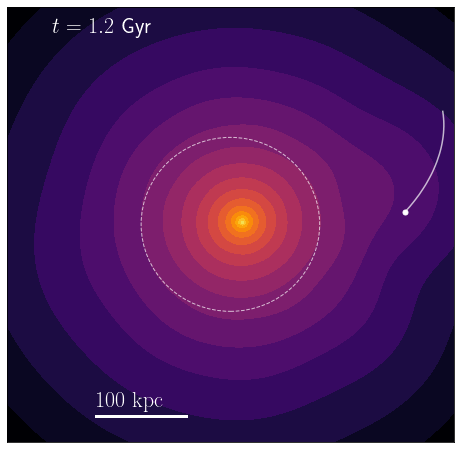

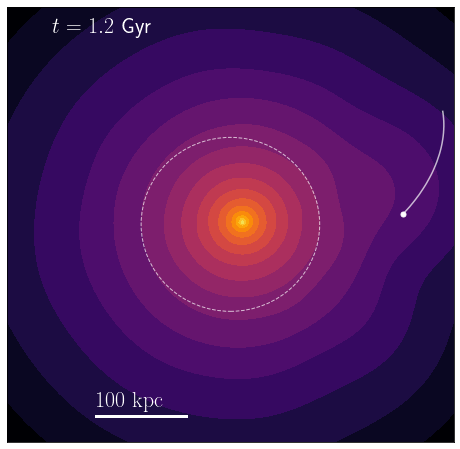

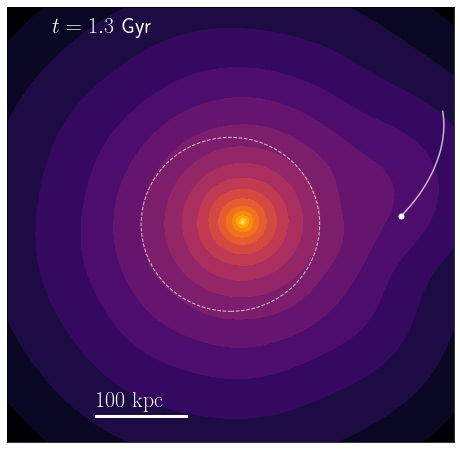

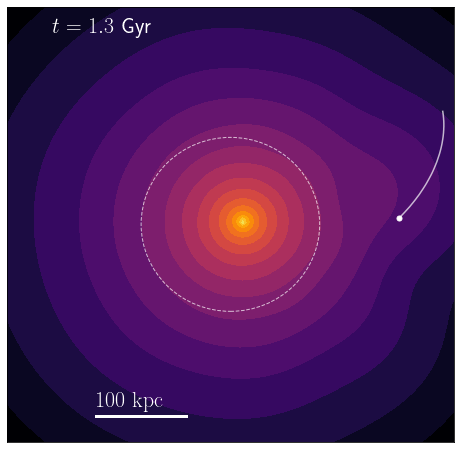

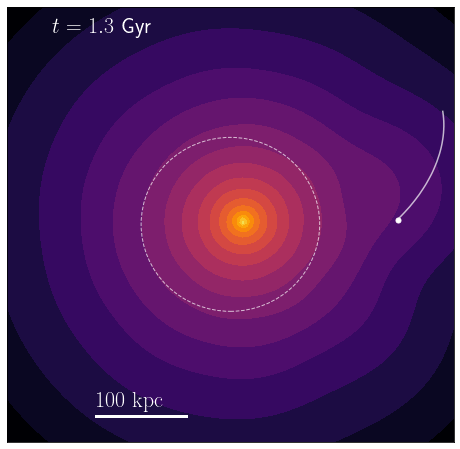

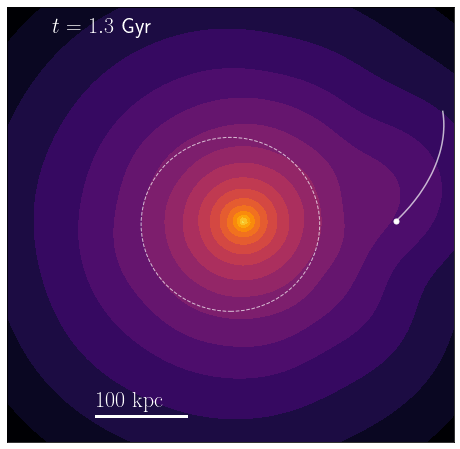

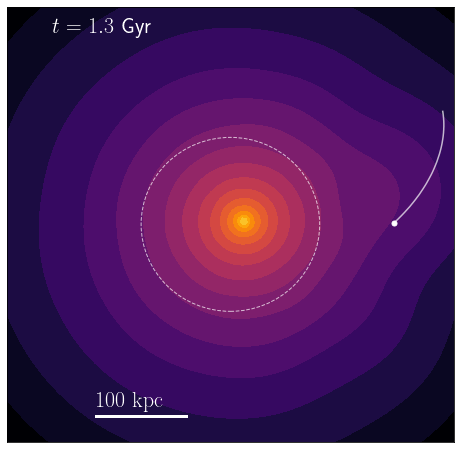

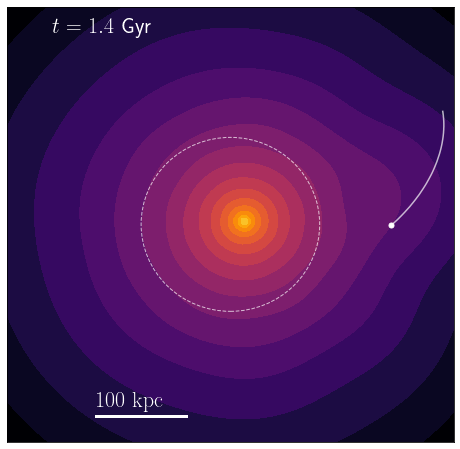

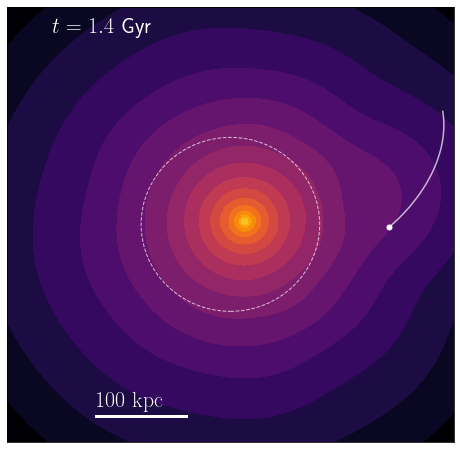

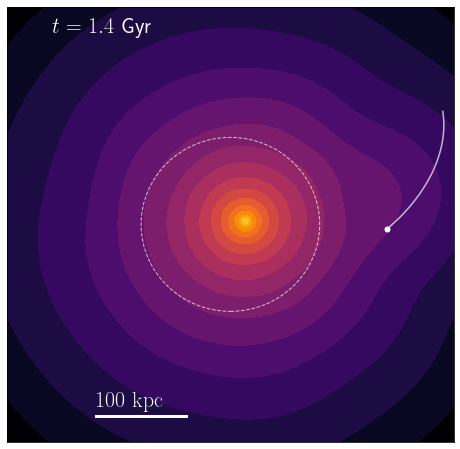

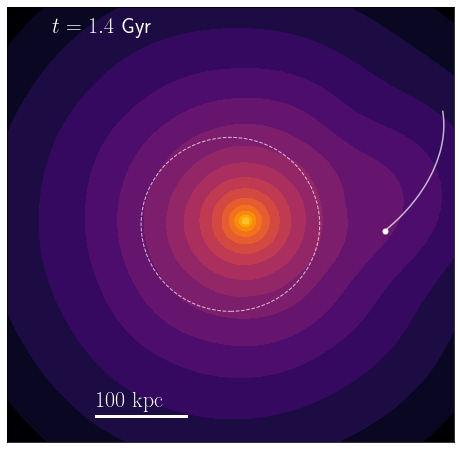

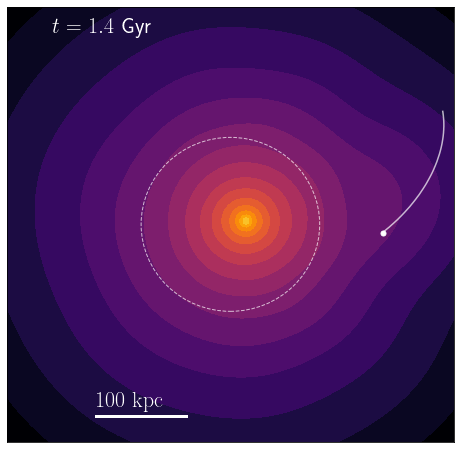

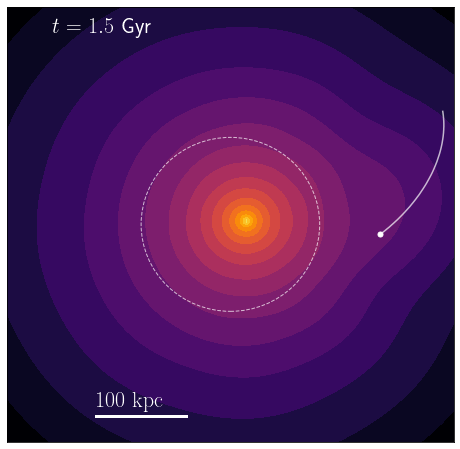

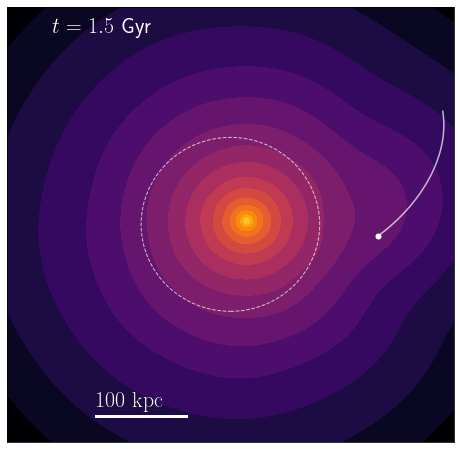

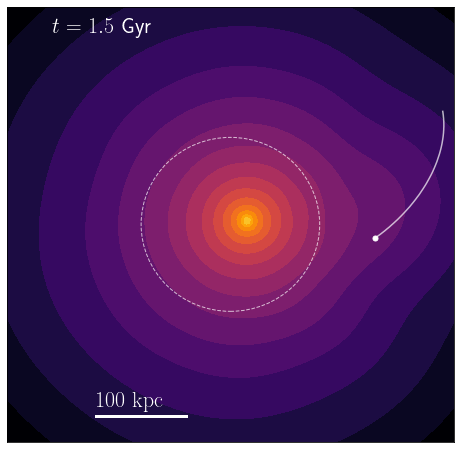

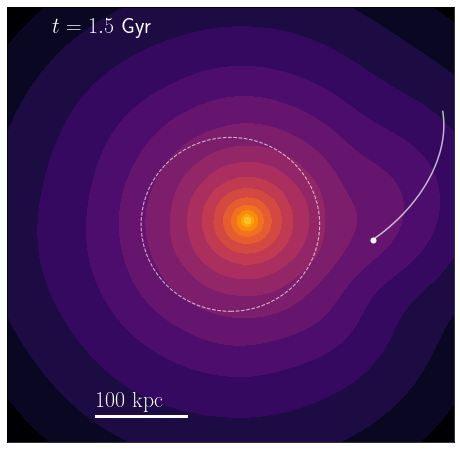

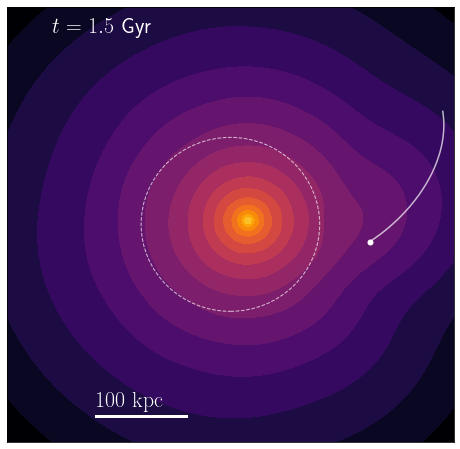

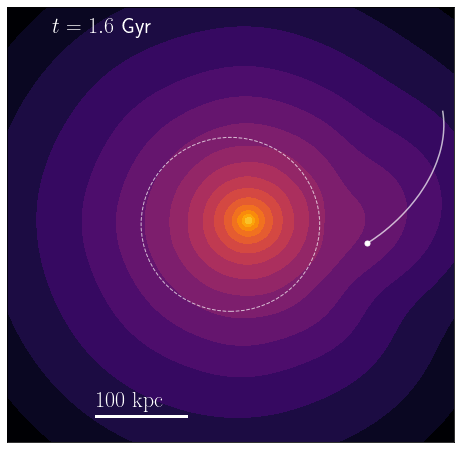

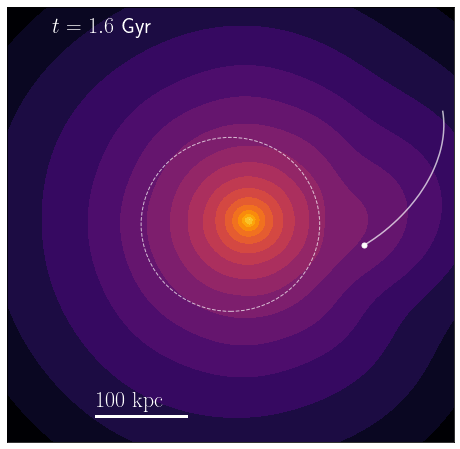

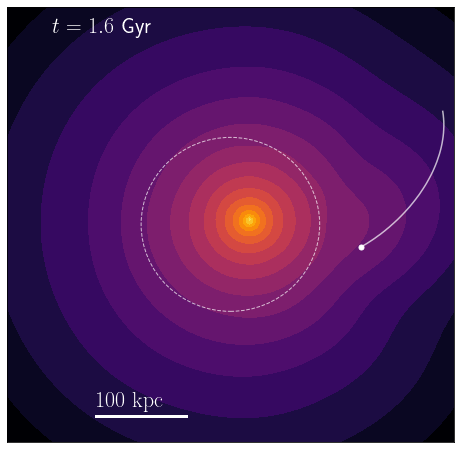

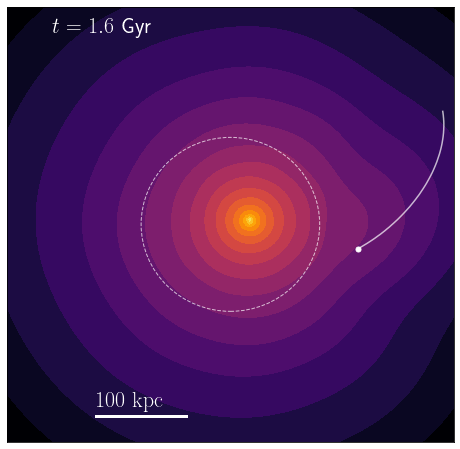

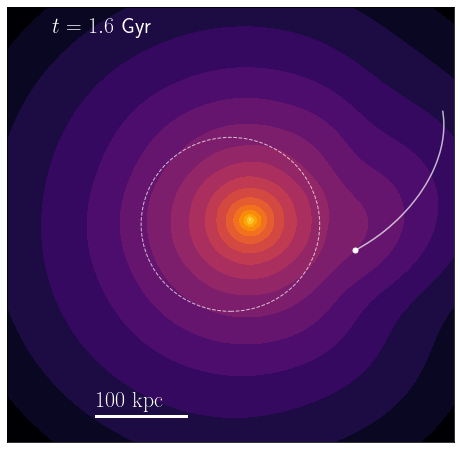

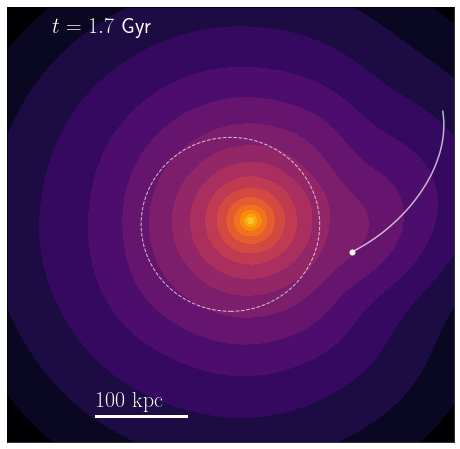

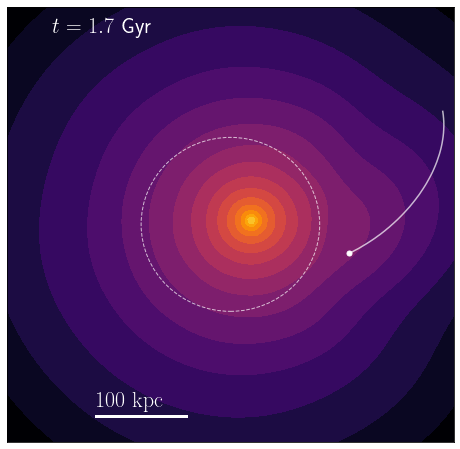

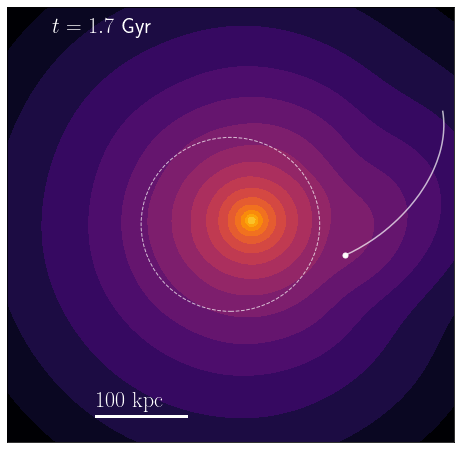

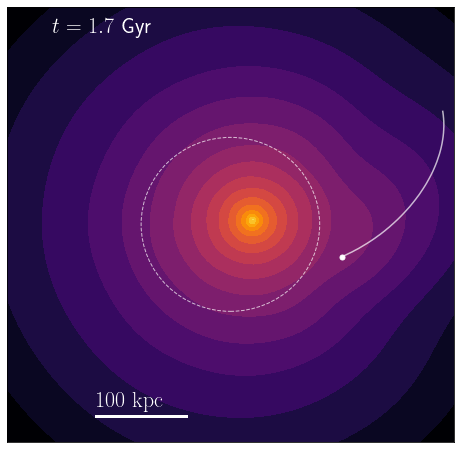

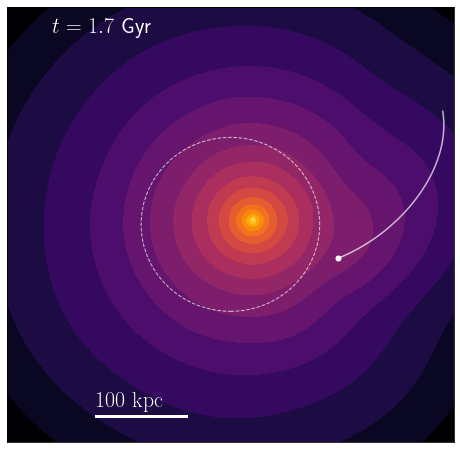

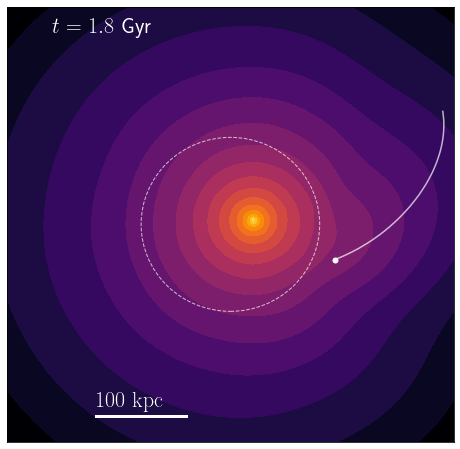

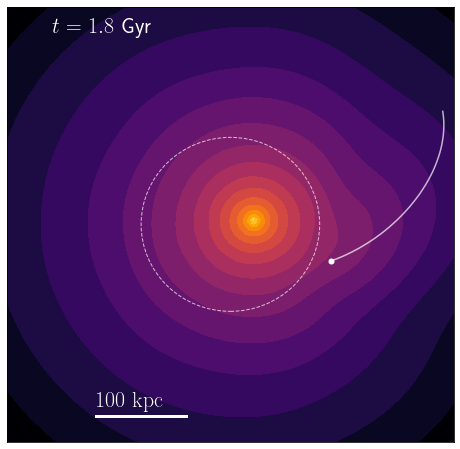

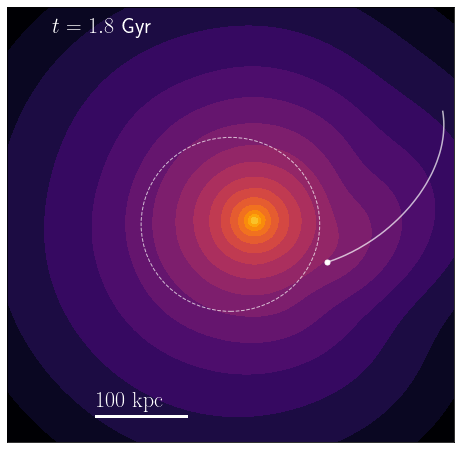

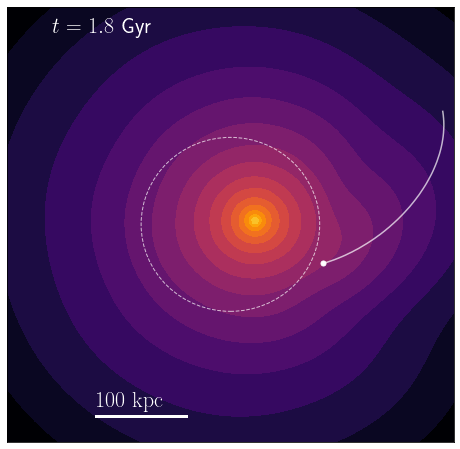

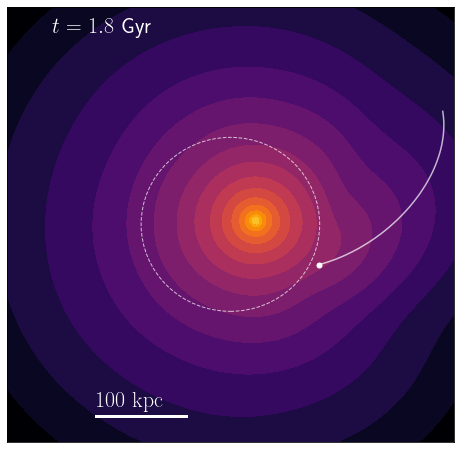

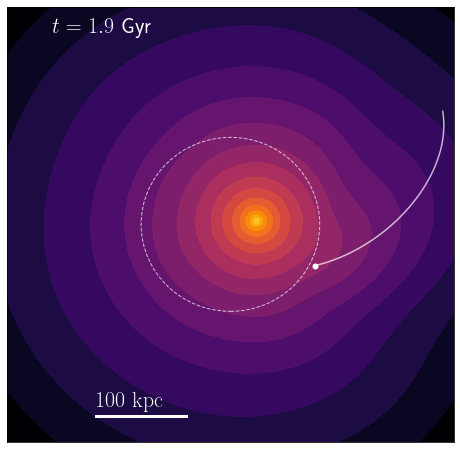

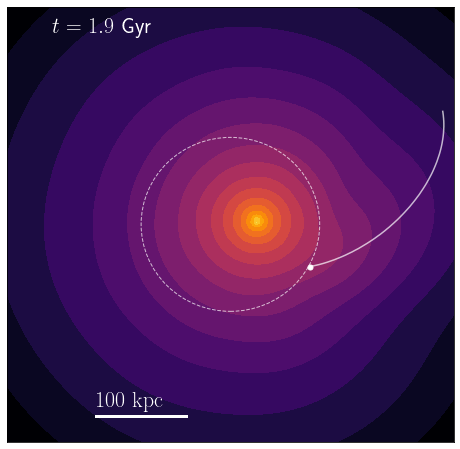

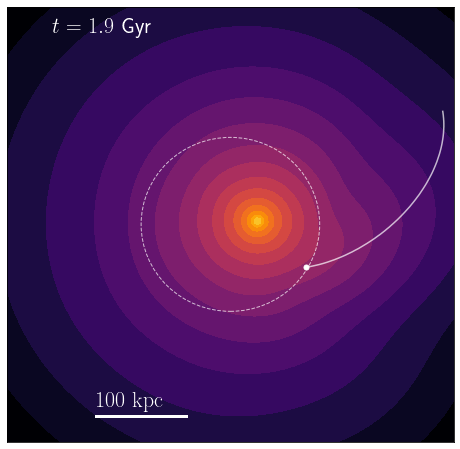

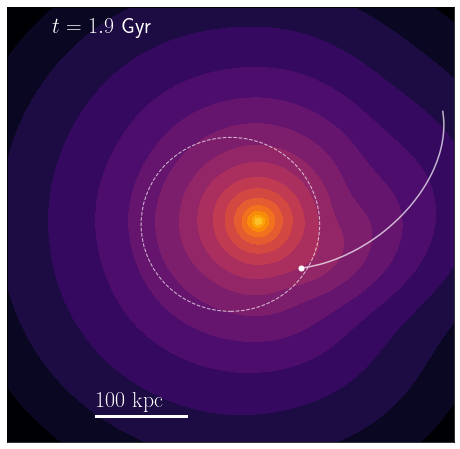

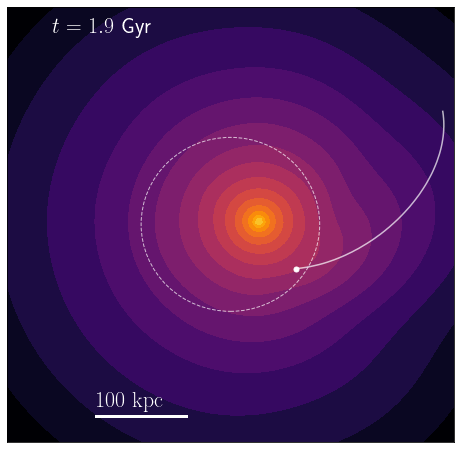

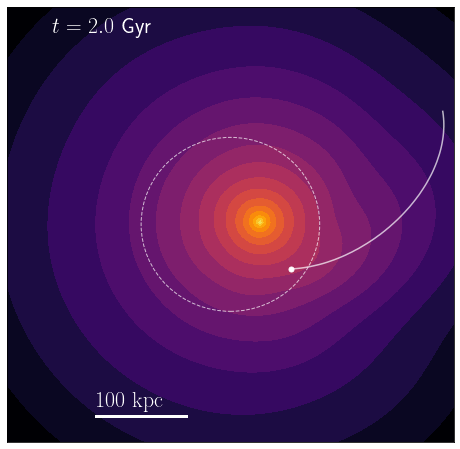

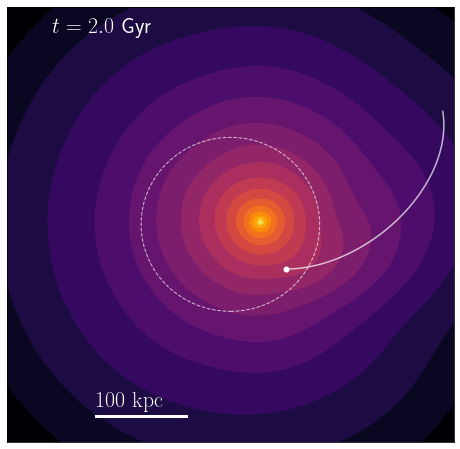

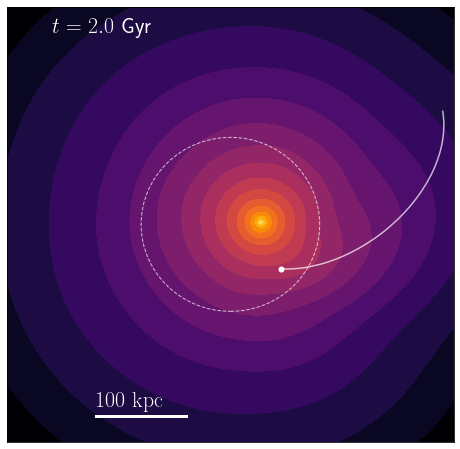

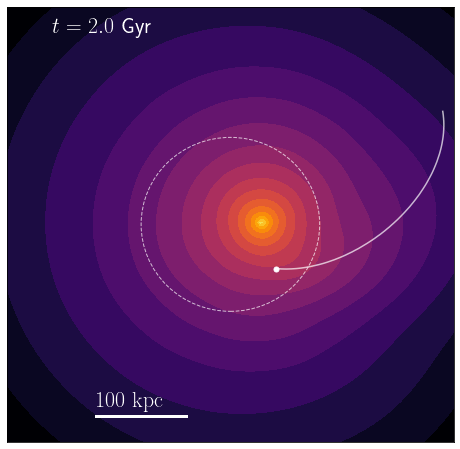

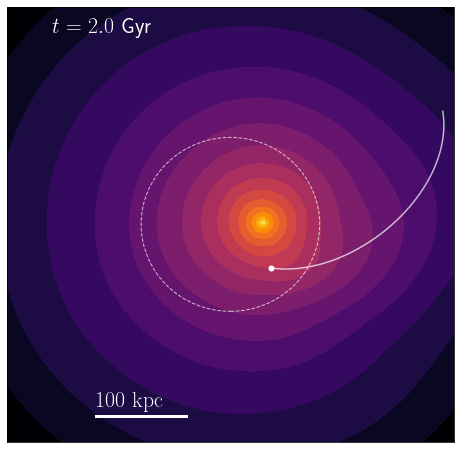

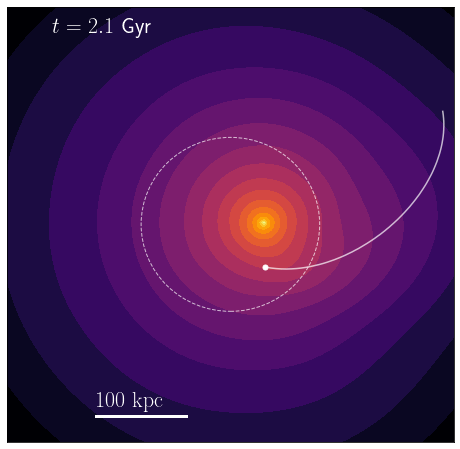

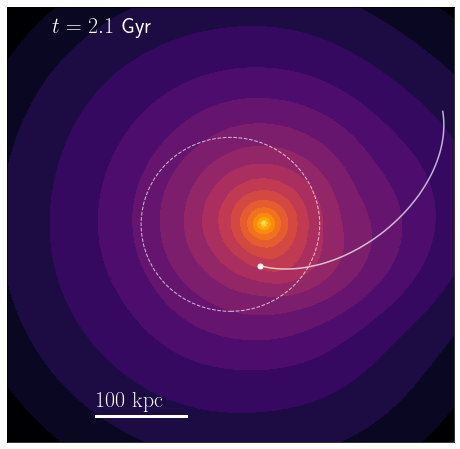

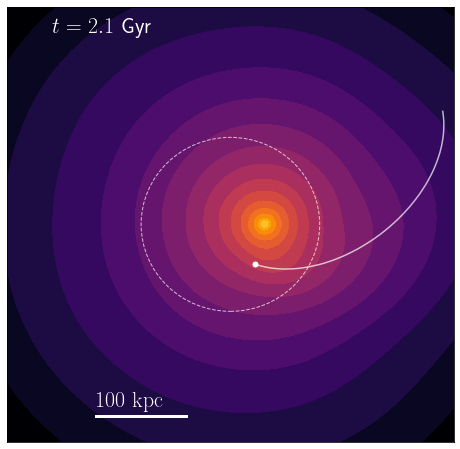

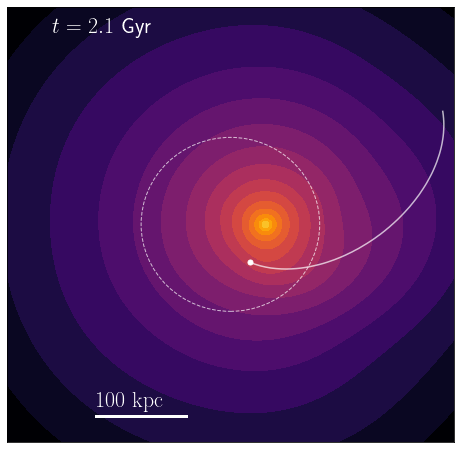

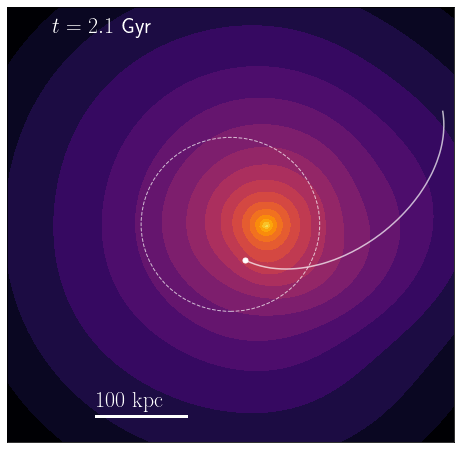

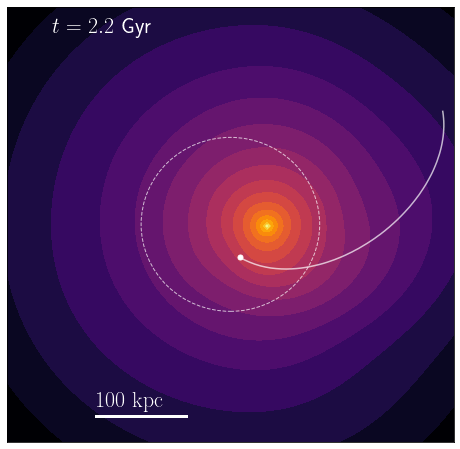

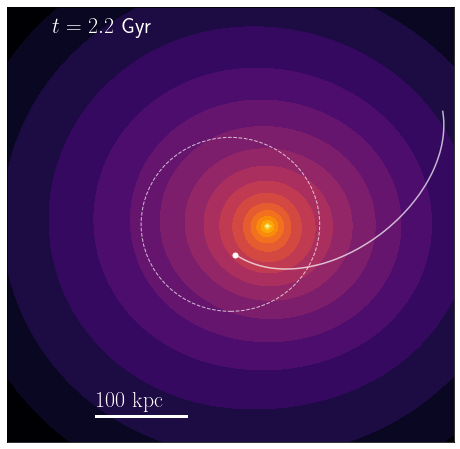

In [132]:
for k in range(110):
    density_profile(S_mw[k], T_mw[k], [-250, 250], m=1, rs=40.85, orbit=orbit[:,0:9], snap=k)

In [129]:
def density_profile_anotated(S, T, grid_size, m, rs, orbit, snap):
    S0 = np.zeros_like(S)
    T0 = np.zeros_like(T)
    S0[0,0,0] = S[0,0,0]
    T0[0,0,0] = T[0,0,0]
    
    circle1 = plt.Circle((0, 0), 100, color='w', fill=False, ls='--', alpha=0.7)

    pot = gp.SCFPotential(m=m*u.Msun, r_s=rs*u.kpc, Snlm=S, Tnlm=T, units=galactic)
    #pot_0 = gp.SCFPotential(m=m*u.Msun, r_s=rs*u.kpc, Snlm=S0, Tnlm=T0, units=galactic)
    
    x0 = np.linspace(grid_size[0], grid_size[1], 128)
    y0 = np.linspace(grid_size[0], grid_size[1], 128)

    x = np.linspace(grid_size[0]-orbit[snap,1], grid_size[1]-orbit[snap,1], 128)
    y = np.linspace(grid_size[0]-orbit[snap,2], grid_size[1]-orbit[snap,2], 128)

    grid = np.meshgrid(x, y)    
    xyz = np.zeros((3, 128**2))
    xyz[1] = grid[0].flatten()
    xyz[2] = grid[1].flatten()
    
    rho = pot.density(xyz)
    #rho_0 = pot_0.density(xyz)

    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    ax.contourf(x0, y0, np.log10(np.abs(rho.value.reshape(128, 128))), 20, cmap='inferno', 
                origin='lower', vmin=-7.5, vmax=-1.5, extent=[-250, 250, -250, 250], levels=np.linspace(-8, -1.5, 20))
    
    #ax.contourf(x0, y0, (rho.value/rho_0.value).reshape(128, 128)-1 , 20, cmap='inferno', 
    #            origin='lower', vmin=-0.4, vmax=0.4, extent=[-250, 250, -250, 250])
    ax.scatter(orbit[snap,7], orbit[snap,8], c='w')
    ax.plot(orbit[:snap+1,7], orbit[:snap+1,8], lw='1.5', c='w', alpha=0.7)
    ax.add_patch(circle1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.plot([-150, -50], [-220, -220], c='w')
    ax.text( -150, -210, r'$\rm{100\ kpc}$', c='w', fontsize=22)
    ax.text( -200, 220, r'$t={:0.1f}\ $Gyr'.format(snap*0.02), c='w', fontsize=22)
    
    ax.annotate("", xy=(orbit[120,7], orbit[120,8]), xytext=(orbit[110,7], orbit[110,8]), arrowprops=dict(arrowstyle="->", color='w'))
    ax.annotate("", xy=(orbit[150,1], orbit[150,2]), xytext=(orbit[110,1], orbit[110,2]), arrowprops=dict(arrowstyle="->", color='k'), )

    savefig('reflex_motion_{:03d}.png'.format(snap), bbox_inches='tight')

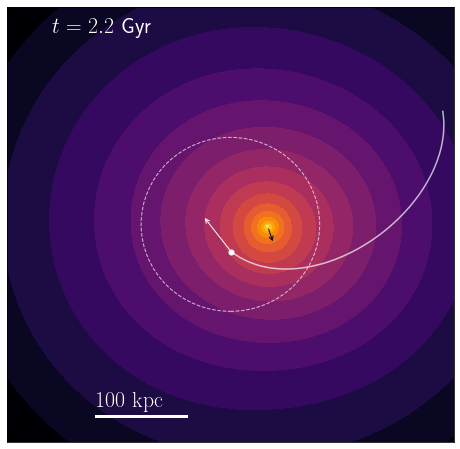

In [133]:
density_profile_anotated(S_mw[k], T_mw[k], [-250, 250], m=1, rs=40.85, orbit=orbit[:,0:9], snap=110)

In [124]:
annotate?